In [15]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from collections import Counter
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
from itertools import product, compress
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile, SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from scipy.spatial import distance

matplotlib.rcParams.update({'font.size': 24})
plt.style.use("ggplot")

PATH_DATA = "../datasets/SARS2/"
PATH_DATA_GHDDI = "../datasets/SAR1/GHDDI"

In [3]:
features_SARS2 = np.load(os.path.join(PATH_DATA, "features_SARS2.npy"))
data_SARS2 = pd.read_csv(os.path.join(PATH_DATA, "dataset_cleaned_SARS2.csv"))
features_SARS1 = np.load(os.path.join(PATH_DATA_GHDDI, "features_SARS1.npy"))
data_SARS1 = pd.read_csv(os.path.join(PATH_DATA_GHDDI, "dataset_cleaned_SARS1.csv"))
features_SARS1_SARS2 = np.load(os.path.join(PATH_DATA, "features_SARS1_SARS2.npy"))
data_SARS1_SARS2 = pd.read_csv(os.path.join(PATH_DATA, "dataset_cleaned_SARS1_SARS2.csv"))
active_SARS1 = data_SARS1["Is_active"].values
active_SARS2 = data_SARS2["Is_active"].values
active_SARS1_SARS2 = data_SARS1_SARS2["Is_active"].values

In [72]:
def domain_analysis(x_train, x_test, y_true_train, y_true_test, folder="output_domain_analysis", output_densities="thresholds_vs_density.png", output_thresholds="threshold_analysis.txt", output_distplots="displot", debug=False, names=None, stack=False, regulardomain=True):
    """
        Adapted from https://github.com/NostrumBioDiscovery/modtox/blob/restructuration/modtox/ML/postprocess.py
    """
    names= ["sample_{}".format(i) for i in range(x_test.shape[0])] if not names else names
    os.makedirs(folder, exist_ok=True)
    ##### computing thresholds #######
    print("Computing applicability domains")
    distances = np.array([distance.cdist([x], x_train) for x in x_train])
    distances_sorted = [np.sort(d[0]) for d in distances]
    d_no_ii = [ d[1:] for d in distances_sorted] #discard 0 for the ii
    k = int(round(pow(len(x_train), 1/3)))

    d_means = [np.mean(d[:k][0]) for d in d_no_ii] #medium values
    Q1 = np.quantile(d_means, .25)
    Q3 = np.quantile(d_means, .75)
    IQR = Q3 - Q1
    d_ref = Q3 + 1.5*(Q3-Q1) #setting the refference value
    n_allowed =  []
    all_allowed = []
    for i in d_no_ii:
        d_allowed = [d for d in i if d <= d_ref]
        all_allowed.append(d_allowed)
        n_allowed.append(len(d_allowed))

    #selecting minimum value not 0:
    min_val = [np.sort(n_allowed)[i] for i in range(len(n_allowed)) if np.sort(n_allowed)[i] != 0]
    #replacing 0's with the min val
    n_allowed = [n if n!= 0 else min_val[0] for n in n_allowed]
    all_d = [sum(all_allowed[i]) for i, d in enumerate(d_no_ii)]
    thresholds = np.divide(all_d, n_allowed) #threshold computation
    thresholds[np.isinf(thresholds)] = min(thresholds) #setting to the minimum value where infinity
    print('Thresholds computed')

    if not stack or regulardomain: weights = 1
    #weight domain by std and bias
    # if stack and not regulardomain:
    #     assert self.y_proba_train.any() and self.y_proba_train_clfs.any()
    #     mean_clfs = []
    #     invstds = [1-np.std(preds) for preds in self.y_proba_train_clfs[:,:,1].T]
    #     biases = [proba[1] if true == 1 else 1 - proba[1] for proba, true in zip(self.y_proba_train, y_true_train)]
    #     weights = np.multiply(invstds, biases)

    thresholds = thresholds*weights

    count_active = []; count_inactive = []

    #now computing distances from train to test

    d_train_test = np.array([distance.cdist([x], x_train) for x in x_test])


    for i, name in zip(d_train_test, names): # for each sample
        idxs = [j for j,d in enumerate(i[0]) if d <= thresholds[j]] #saving indexes of training with threshold > distance
        count_active.append(len([y_true_train.tolist()[i] for i in idxs if y_true_train[i] == 1]))
        count_inactive.append(len([y_true_train.tolist()[i] for i in idxs if y_true_train[i] == 0]))

    n_insiders = np.array(count_active) + np.array(count_inactive)
    mean_insiders = np.mean(n_insiders)
    #we include uncertainties in the txt file
    # uncert = self.calculate_uncertanties() 
    df = pd.DataFrame()
    df['Names'] = names
    df['Thresholds'] = n_insiders
    df['Active thresholds'] = count_active
    df['Inactive thresholds'] = count_inactive
    df['True labels'] = y_true_test
    # df['Prediction'] = y_pred_test
    # df['Prediction probability'] = np.array([pred_1[1] for pred_1 in self.y_proba_test])
    # df['Uncertainties'] = np.array(uncert)
    df = df.sort_values(by=['Thresholds'], ascending = False) 

    with open(os.path.join(folder, output_thresholds), "w") as f:
        f.write(df.to_string())

    c = Counter(n_allowed)
    print(c)
    #####   plotting results ######


    if not debug:

        print('Plotting')
        plt.figure(figsize=(8,8))
        scatter = plt.scatter(n_allowed, thresholds, c=y_true_train)
        plt.xlabel('Density')
        plt.ylabel('Threshold')
        legend1 = plt.legend(*scatter.legend_elements(),loc="best", title="Classes")
        plt.gca().add_artist(legend1)
        plt.savefig(os.path.join(folder, output_densities), dpi=300)
        plt.close()

        for j in tqdm(range(len(names))):
            #plotting 
            fig, ax1 = plt.subplots(figsize=(8,8))
            sns.distplot(d_train_test[j], label='Distances to train molecules', ax=ax1)
            sns.distplot(thresholds, label='Thresholds of train molecules', ax=ax1)
            ax1.set_xlabel('Euclidean distances')
            ax1.set_ylabel('Normalized counts')
            ax1.legend()

            ax2 = ax1.twinx()

            ax2.axhline(mean_insiders, ls='--', color='r', label='Mean App. Domain Membership')
            ax2.axhline(n_insiders[j], ls='-', color='g', label='App. Domain Membership')
            ax2.set_ylim(min(n_insiders)-1, max(n_insiders)+1)
            ax2.set_ylabel('App.Domain counts')
            fig.tight_layout()
            ax2.legend(loc='center right')
            plt.title('{}'.format(names[j]))
            plt.savefig(os.path.join(folder, '{}_{}.png'.format(output_distplots, names[j])), dpi=300)
            plt.close()
        
        plt.figure(figsize=(8,8))
        plt.hist(n_insiders, bins=20)
        plt.xlabel("App. Domain Membership")
        plt.savefig(os.path.join(folder, "histogram_n_insiders.png"), dpi=300)
        plt.close()
    return n_insiders


In [73]:
inside_AP_SARS1 = domain_analysis(features_SARS1, features_SARS2, active_SARS1, active_SARS2, folder="output_domain_analysis_SARS1")

Computing applicability domains
Thresholds computed
Counter({1: 54, 61: 51, 24: 29, 12: 20, 11: 19, 7: 19, 10: 13, 14: 11, 6: 11, 33: 10, 2: 9, 4: 9, 23: 9, 5: 9, 9: 9, 3: 8, 25: 8, 8: 7, 16: 7, 31: 7, 13: 7, 19: 6, 26: 6, 15: 6, 63: 6, 28: 5, 32: 5, 21: 5, 18: 4, 17: 4, 29: 3, 35: 3, 34: 3, 20: 3, 22: 3, 62: 3, 36: 2, 59: 2, 30: 1, 39: 1, 27: 1})
Plotting


100%|██████████| 166/166 [01:57<00:00,  1.42it/s]


In [74]:
inside_AP_SARS2 = domain_analysis(features_SARS2, features_SARS1, active_SARS2, active_SARS1, folder="output_domain_analysis_SARS2")

Computing applicability domains
Thresholds computed
Counter({161: 47, 160: 26, 159: 21, 158: 15, 157: 9, 156: 8, 152: 5, 149: 3, 155: 3, 153: 3, 151: 2, 162: 2, 147: 2, 154: 2, 148: 2, 2: 2, 163: 1, 4: 1, 141: 1, 125: 1, 150: 1, 146: 1, 130: 1, 121: 1, 134: 1, 54: 1, 85: 1, 3: 1, 98: 1, 132: 1})
Plotting


100%|██████████| 398/398 [04:48<00:00,  1.38it/s]


In [75]:
train_data, test_data, train_labels, test_labels = train_test_split(features_SARS1_SARS2, active_SARS1_SARS2, test_size=0.25, random_state=42, stratify=active_SARS1_SARS2)

In [76]:
inside_AP_combined = domain_analysis(train_data, test_data, train_labels, test_labels, folder="output_domain_analysis_combined")

Computing applicability domains
Thresholds computed
Counter({418: 167, 420: 62, 417: 60, 419: 59, 416: 20, 415: 12, 413: 8, 414: 7, 412: 6, 411: 3, 406: 2, 409: 2, 400: 2, 381: 2, 410: 1, 133: 1, 407: 1, 346: 1, 67: 1, 374: 1, 404: 1, 405: 1, 376: 1})
Plotting


100%|██████████| 141/141 [01:45<00:00,  1.34it/s]


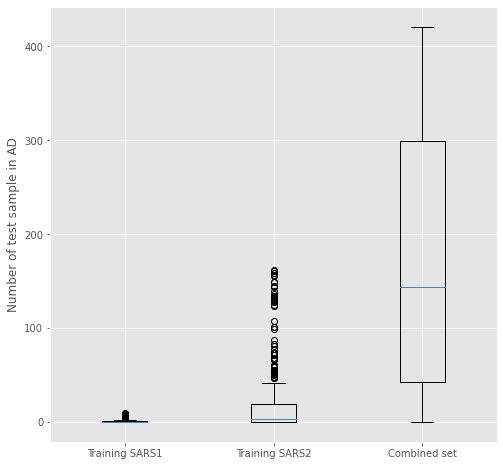

In [84]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.boxplot([inside_AP_SARS1, inside_AP_SARS2, inside_AP_combined])
axes.set(xticklabels=["Training SARS1", "Training SARS2", "Combined set"]);
axes.set_ylabel("Number of test sample in AD");

In [78]:
inside_AP_combined.shape

(141,)

In [79]:
best = [864, 2, 878, 118, 504, 157, 446, 31]
features_SARS1_SARS2_best = features_SARS1_SARS2[:, best]
features_SARS1_best = features_SARS1[:, best]
features_SARS2_best = features_SARS2[:, best]

train_data_best, test_data_best, train_labels_best, test_labels_best = train_test_split(features_SARS1_SARS2_best, active_SARS1_SARS2, test_size=0.25, random_state=42, stratify=active_SARS1_SARS2)

In [80]:
inside_AP_SARS1_best = domain_analysis(features_SARS1_best, features_SARS2_best, active_SARS1, active_SARS2, folder="output_domain_analysis_SARS1_best")

Computing applicability domains
Thresholds computed
Counter({235: 236, 43: 44, 21: 22, 16: 17, 14: 15, 2: 15, 3: 12, 10: 11, 9: 10, 7: 8, 1: 8})
Plotting


  0%|          | 0/166 [00:00<?, ?it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  1%|          | 1/166 [00:00<01:58,  1.40it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  1%|          | 2/166 [00:01<01:57,  1.39it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  2%|▏         | 3/166 [00:02<01:53,  1.43it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings

 19%|█▉        | 32/166 [00:21<01:31,  1.47it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 20%|█▉        | 33/166 [00:22<01:30,  1.48it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 20%|██        | 34/166 [00:22<01:28,  1.49it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 21%|██        | 35/166 [00:23<01:26,  1.52it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate

 39%|███▊      | 64/166 [00:43<01:09,  1.47it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 39%|███▉      | 65/166 [00:43<01:07,  1.50it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 40%|███▉      | 66/166 [00:44<01:16,  1.31it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 40%|████      | 67/166 [00:45<01:13,  1.35it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate

 58%|█████▊    | 96/166 [01:04<00:48,  1.45it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 58%|█████▊    | 97/166 [01:05<00:46,  1.48it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 59%|█████▉    | 98/166 [01:06<00:46,  1.48it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 60%|█████▉    | 99/166 [01:06<00:44,  1.51it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate

 77%|███████▋  | 128/166 [01:26<00:26,  1.43it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 78%|███████▊  | 129/166 [01:27<00:25,  1.43it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 78%|███████▊  | 130/166 [01:27<00:24,  1.46it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 79%|███████▉  | 131/166 [01:28<00:23,  1.46it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density esti

 96%|█████████▋| 160/166 [01:47<00:04,  1.49it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 97%|█████████▋| 161/166 [01:48<00:03,  1.49it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 98%|█████████▊| 162/166 [01:49<00:03,  1.17it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 98%|█████████▊| 163/166 [01:50<00:02,  1.23it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density esti

In [81]:
inside_AP_SARS2_best = domain_analysis(features_SARS2_best, features_SARS1_best, active_SARS2, active_SARS1, folder="output_domain_analysis_SARS2_best")

Computing applicability domains
Thresholds computed
Counter({119: 120, 1: 12, 9: 10, 2: 9, 8: 9, 5: 6})
Plotting


  0%|          | 0/398 [00:00<?, ?it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  0%|          | 1/398 [00:00<04:28,  1.48it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  1%|          | 2/398 [00:01<04:27,  1.48it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/jgilaber/anaconda

  7%|▋         | 27/398 [00:17<03:54,  1.58it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  7%|▋         | 28/398 [00:17<03:54,  1.58it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  7%|▋         | 29/398 [00:18<03:55,  1.56it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  8%|▊         | 30/398 [00:19<03:56,  1.56it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation

 14%|█▎        | 54/398 [00:36<04:25,  1.29it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 14%|█▍        | 55/398 [00:36<04:11,  1.36it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 14%|█▍        | 56/398 [00:37<04:01,  1.42it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 14%|█▍     

 20%|██        | 81/398 [00:53<03:29,  1.51it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 21%|██        | 82/398 [00:53<03:25,  1.54it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 21%|██        | 83/398 [00:54<03:31,  1.49it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 21%|██     

 28%|██▊       | 112/398 [01:13<03:28,  1.37it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 28%|██▊       | 113/398 [01:14<03:19,  1.43it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 29%|██▊       | 114/398 [01:14<03:12,  1.47it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 29%|██▉       | 115/398 [01:15<03:07,  1.51it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estima

 35%|███▌      | 141/398 [01:32<02:47,  1.53it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 36%|███▌      | 142/398 [01:33<02:45,  1.54it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 36%|███▌      | 143/398 [01:33<02:42,  1.57it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 36%|███▌      | 144/398 [01:34<02:42,  1.57it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density esti

 42%|████▏     | 168/398 [01:50<02:27,  1.56it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 42%|████▏     | 169/398 [01:51<02:28,  1.54it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 43%|████▎     | 170/398 [01:52<02:29,  1.52it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 43%|████

 49%|████▊     | 194/398 [02:07<02:15,  1.50it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 49%|████▉     | 195/398 [02:08<02:15,  1.50it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 49%|████▉     | 196/398 [02:09<02:15,  1.49it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 49%|████▉     | 197/398 [02:09<02:13,  1.50it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density esti

 56%|█████▌    | 221/398 [02:26<01:53,  1.56it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 56%|█████▌    | 222/398 [02:26<01:52,  1.57it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 56%|█████▌    | 223/398 [02:27<01:51,  1.57it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 56%|█████▋    | 224/398 [02:28<01:51,  1.56it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density esti

 63%|██████▎   | 249/398 [02:44<01:36,  1.55it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 63%|██████▎   | 250/398 [02:44<01:35,  1.55it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 63%|██████▎   | 251/398 [02:45<01:35,  1.55it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 63%|████

 69%|██████▉   | 276/398 [03:06<01:24,  1.45it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 70%|██████▉   | 277/398 [03:06<01:23,  1.45it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 70%|██████▉   | 278/398 [03:07<01:23,  1.44it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 70%|███████   | 279/398 [03:08<01:23,  1.43it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density esti

 76%|███████▌  | 303/398 [03:24<01:07,  1.41it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 76%|███████▋  | 304/398 [03:25<01:06,  1.42it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 77%|███████▋  | 305/398 [03:26<01:05,  1.41it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 77%|████

 83%|████████▎ | 331/398 [03:44<00:55,  1.21it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 83%|████████▎ | 332/398 [03:45<00:53,  1.22it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 84%|████████▎ | 333/398 [03:46<00:49,  1.30it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 84%|████████▍ | 334/398 [03:46<00:46,  1.36it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density esti

 90%|████████▉ | 358/398 [04:03<00:26,  1.52it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 90%|█████████ | 359/398 [04:03<00:25,  1.53it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 90%|█████████ | 360/398 [04:04<00:24,  1.53it/s]/home/jgi

 97%|█████████▋| 386/398 [04:21<00:08,  1.45it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 97%|█████████▋| 387/398 [04:22<00:07,  1.44it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 97%|█████████▋| 388/398 [04:23<00:06,  1.45it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 98%|█████████▊| 389/398 [04:23<00:06,  1.46it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density esti

In [82]:
inside_AP_combined_best = domain_analysis(train_data_best, test_data_best, train_labels_best, test_labels_best, folder="output_domain_analysis_combined_best")

Computing applicability domains
Thresholds computed
Counter({262: 263, 34: 35, 23: 24, 21: 22, 1: 17, 14: 15, 10: 11, 8: 9, 3: 8, 2: 6, 5: 6, 4: 5})
Plotting


  0%|          | 0/141 [00:00<?, ?it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  1%|          | 1/141 [00:00<01:35,  1.47it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  1%|▏         | 2/141 [00:01<01:34,  1.47it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
  2%|▏         | 3/141 [00:02<01:35,  1.45it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings

 23%|██▎       | 32/141 [00:24<01:12,  1.50it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 23%|██▎       | 33/141 [00:24<01:13,  1.48it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 24%|██▍       | 34/141 [00:25<01:14,  1.44it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 25%|██▍       | 35/141 [00:26<01:15,  1.40it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate

 45%|████▍     | 63/141 [00:45<00:56,  1.38it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 45%|████▌     | 64/141 [00:46<00:55,  1.39it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 46%|████▌     | 65/141 [00:47<00:53,  1.43it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 47%|████▋     | 66/141 [00:47<00:51,  1.45it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate

 67%|██████▋   | 95/141 [01:07<00:31,  1.44it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 68%|██████▊   | 96/141 [01:08<00:31,  1.45it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 69%|██████▉   | 97/141 [01:09<00:30,  1.45it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 70%|██████▉   | 98/141 [01:09<00:28,  1.48it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate

 89%|████████▉ | 126/141 [01:29<00:10,  1.45it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 90%|█████████ | 127/141 [01:29<00:09,  1.44it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 91%|█████████ | 128/141 [01:30<00:09,  1.44it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
 91%|█████████▏| 129/141 [01:31<00:08,  1.47it/s]/home/jgilaber/anaconda3/envs/drug_learning/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density esti

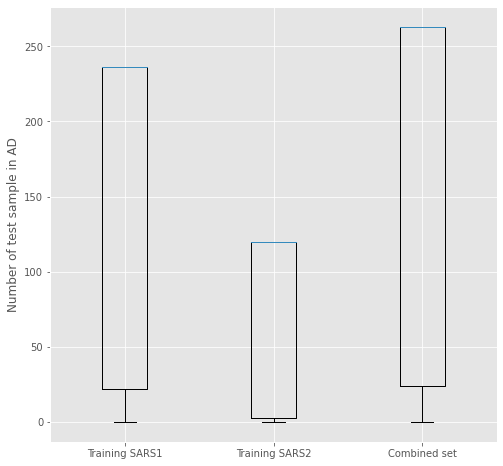

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))
axes.boxplot([inside_AP_SARS1_best, inside_AP_SARS2_best, inside_AP_combined_best])
axes.set(xticklabels=["Training SARS1", "Training SARS2", "Combined set"]);
axes.set_ylabel("Number of test sample in AD");